In [1]:
import sys
import numpy as np
import pandas as pd

from Dissects.io import (load_NDskl, 
                         load_image,
                         load_skeleton,
                         save_skeleton,
                         save_fits
                        )
from Dissects.image import (z_project, thinning)
from Dissects.geometry import Skeleton
from Dissects.segmentation.seg_2D import (segmentation, 
                                          junction_around_cell,
                                         vertices,
                                         junctions)
from Dissects.analysis.analysis import (general_analysis,
                              cellstats
                              )

%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# load image
image, metadata = load_image("/home/tmerle/DISSECT/Dissects4/Dissects/stores/2d_images.tif")


In [3]:
metadata

{'pixel_ratio': 0.18323109343704702, 'height': 337, 'width': 576}

In [4]:
pixel_ratio = metadata['pixel_ratio']

In [5]:
pixel_ratio

0.18323109343704702

In [6]:
#load ndskl file 
cp, fil, point, specs = load_NDskl("/home/tmerle/DISSECT/Dissects4/Dissects/stores/2d_images.NDskl.a.NDskl")
#create skeleton object
#skel = Skeleton(cp, fil, point, specs)


In [7]:
# Load skeleton
data = load_skeleton('2d_skeleton.hf5')
skel = Skeleton(data['critical_point'], data['filament'], data['point'])

/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:25: UserWarning: Has pixel can be half pixel from DisPerSE output,                   we take the integer part of xyz values. 
  we take the integer part of xyz values. ")


In [8]:
#Clean skeleton
skel.remove_lonely_cp()
skel.remove_free_filament()

/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:61: UserWarning: specs dictionnary is not updated, ncrit value is not updated.
  "specs dictionnary is not updated, ncrit value is not updated.")


<IPython.core.display.Javascript object>


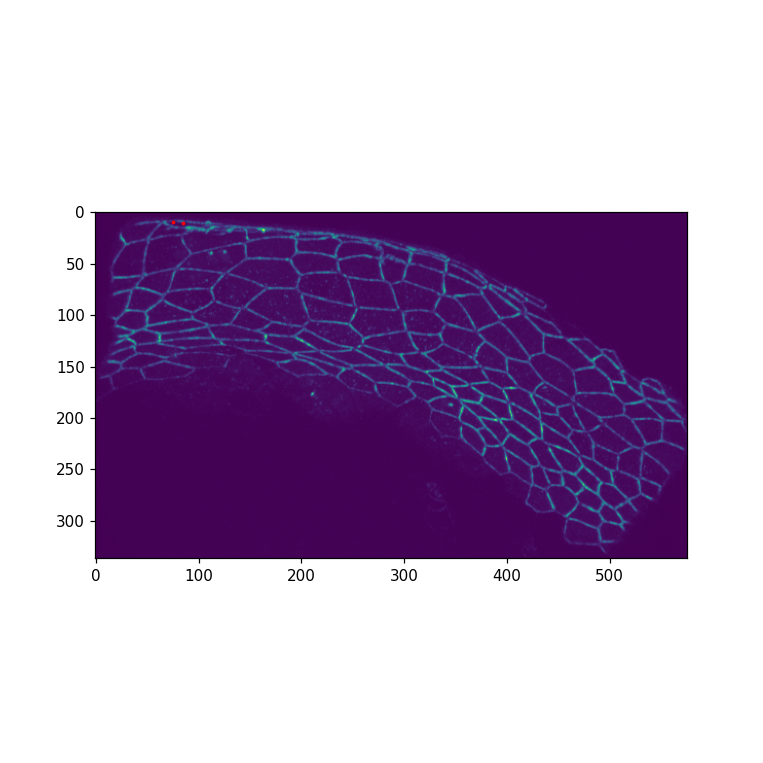

<IPython.core.display.Javascript object>


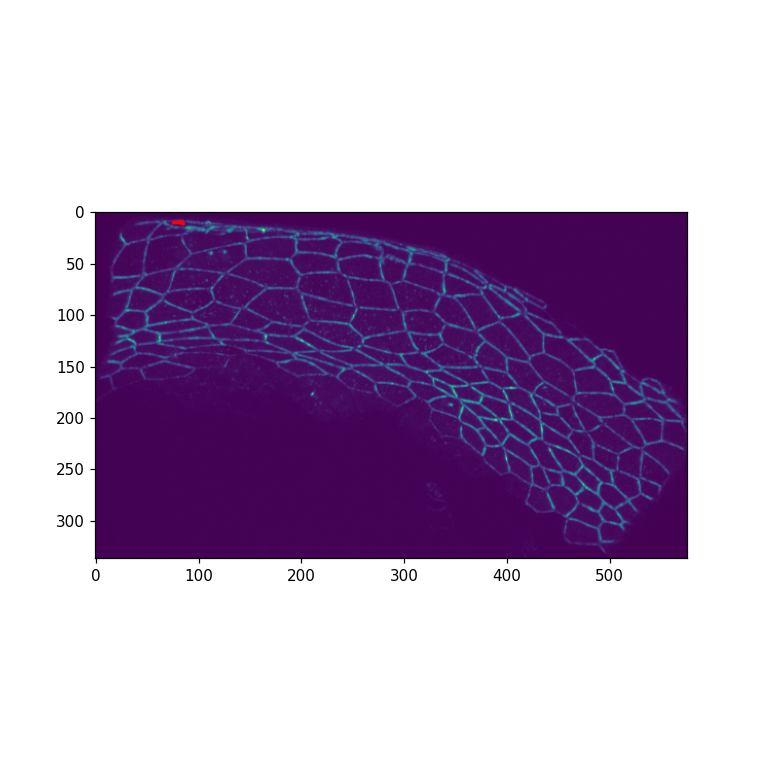

In [9]:
plt.figure(figsize=(7,7))
plt.imshow(image)
plt.scatter(skel.critical_point.loc[skel.filament.loc[0].cp1]['x'],
            skel.critical_point.loc[skel.filament.loc[0].cp1]['y'],
            color='red', s=2)
plt.scatter(skel.critical_point.loc[skel.filament.loc[0].cp2]['x'],
            skel.critical_point.loc[skel.filament.loc[0].cp2]['y'],
            color='red', s=2)

plt.figure(figsize=(7,7))
plt.imshow(image)
plt.scatter(skel.point[skel.point['filament']==0]['x'],
            skel.point[skel.point['filament']==0]['y'],
            color='red', s=2)
    
    

In [32]:
skel.specs = specs
mask = skel.create_binary_image()

In [33]:
print(mask)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<IPython.core.display.Javascript object>


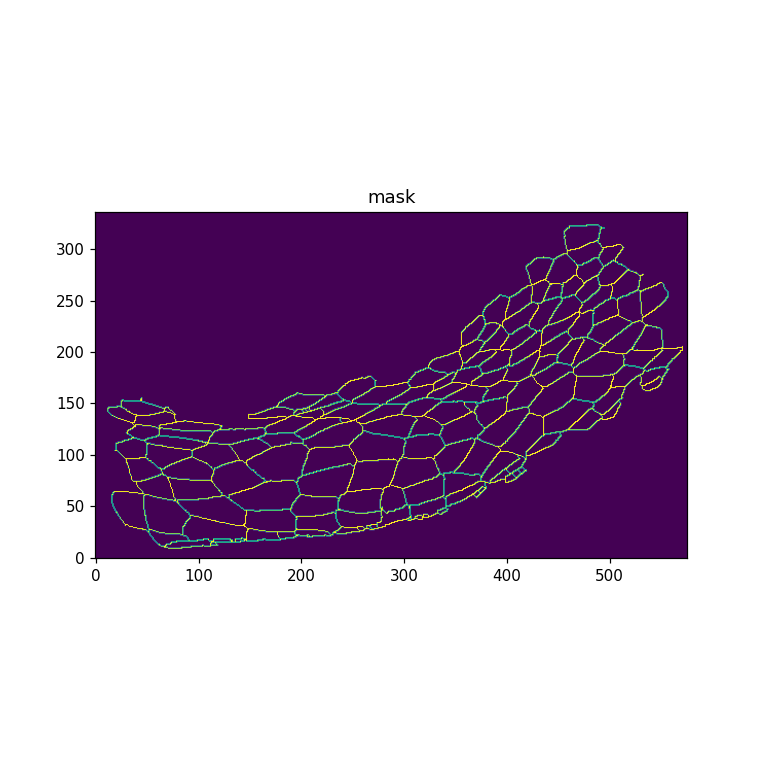

<IPython.core.display.Javascript object>


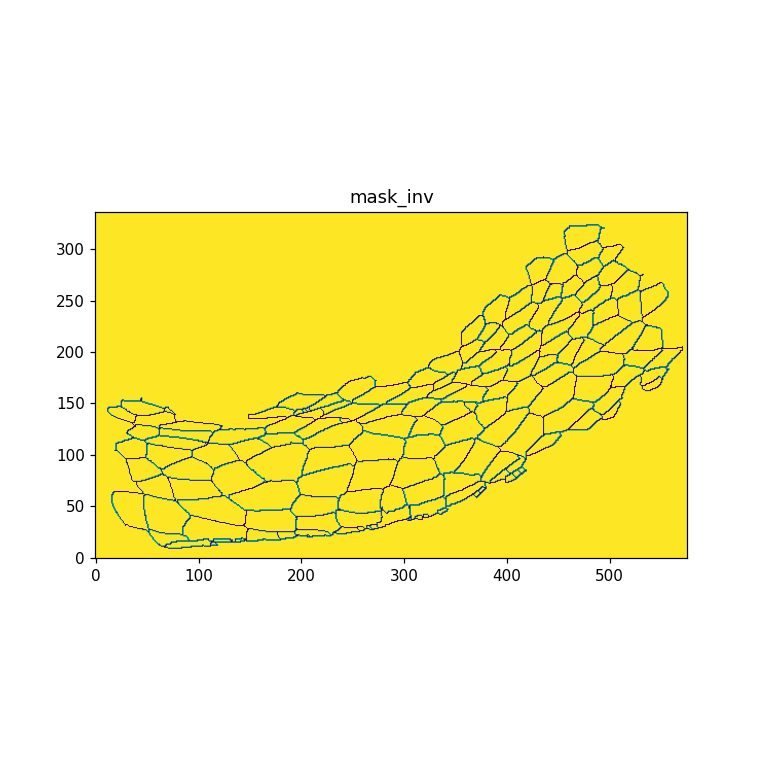

Text(0.5, 1.0, 'mask_inv')

In [37]:
mask = mask.astype(int)
plt.figure(figsize=(7,7))
plt.imshow(mask, origin='lower')
plt.title('mask')


mask_inv = ((~mask.astype(bool)).astype(int))
mask_inv = mask_inv.astype(int)
plt.figure(figsize=(7,7))
plt.imshow(mask_inv, origin='lower')
plt.title('mask_inv')

<IPython.core.display.Javascript object>


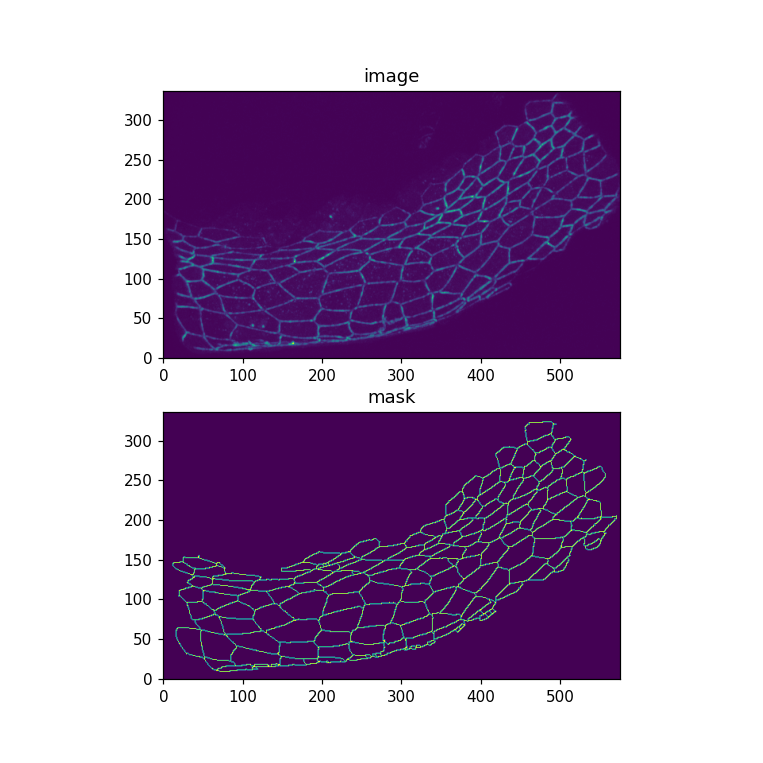

Text(0.5, 1.0, 'mask')

In [38]:
plt.figure(figsize=(7,7))
ax1 = plt.subplot(2,1,1)
ax1.imshow(image, origin='lower')
ax1.set_title('image')
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(mask, origin='lower')
ax2.set_title('mask')



<IPython.core.display.Javascript object>


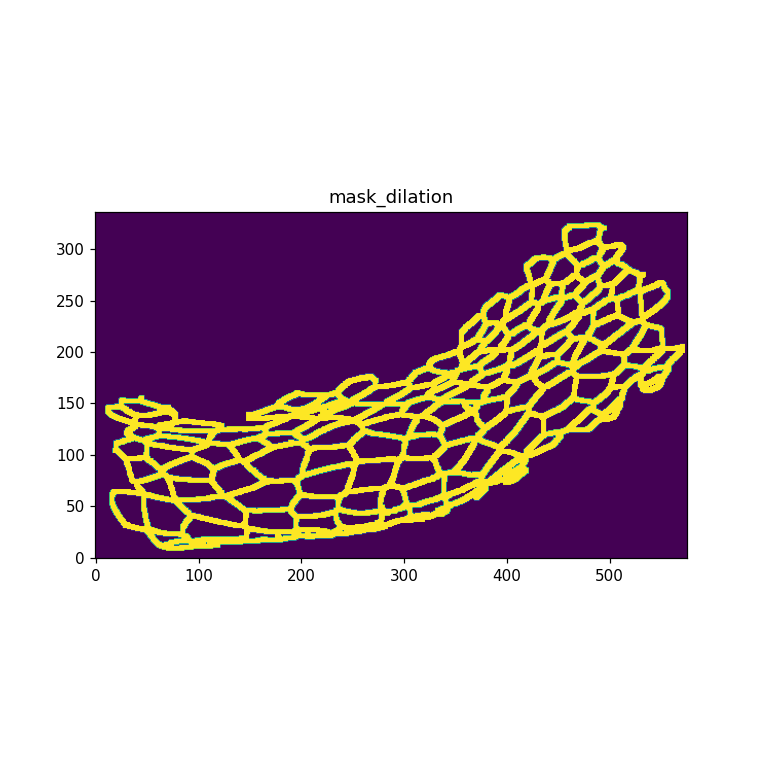

<IPython.core.display.Javascript object>


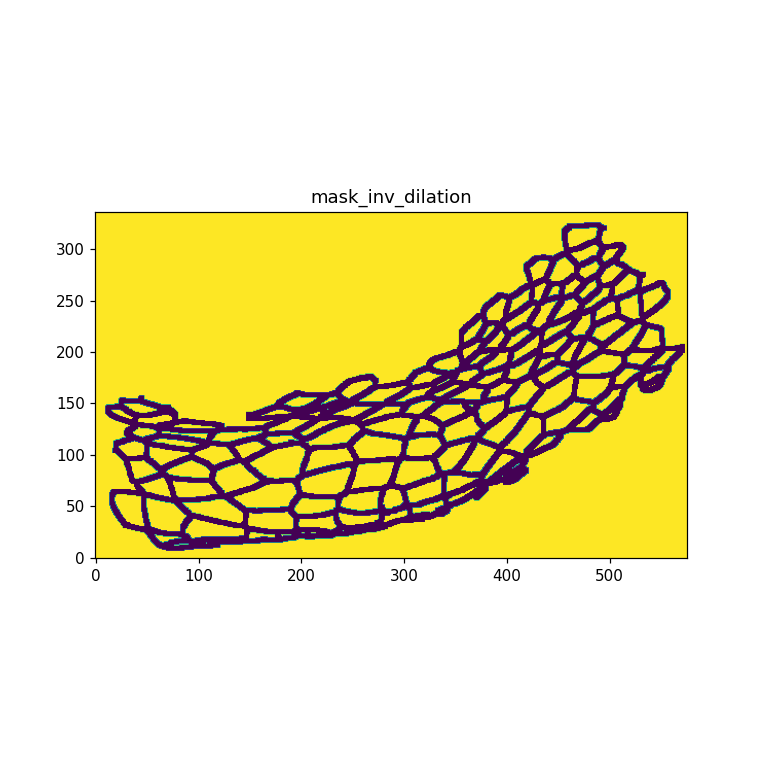

Text(0.5, 1.0, 'mask_inv_dilation')

In [39]:
from Dissects.image import dilation
# elargissement
mask_dilation = dilation(mask, 2)
plt.figure(figsize=(7,7))
plt.imshow(mask_dilation, origin='lower')
plt.title('mask_dilation')

mask_inv_dilation = (~mask_dilation.astype(bool)).astype(int)
plt.figure(figsize=(7,7))
plt.imshow(mask_inv_dilation,origin='lower')
plt.title('mask_inv_dilation')



<IPython.core.display.Javascript object>


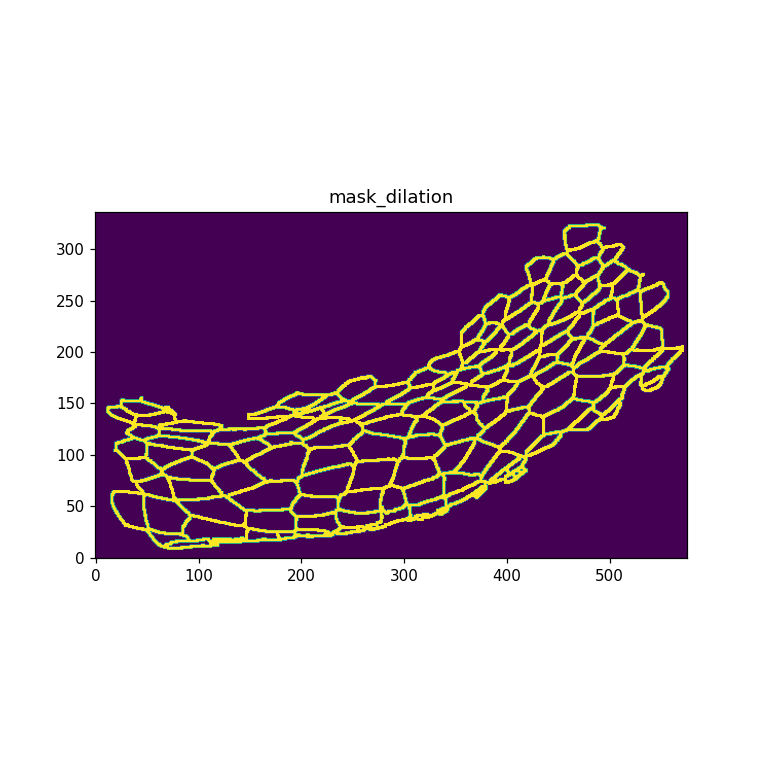

<IPython.core.display.Javascript object>


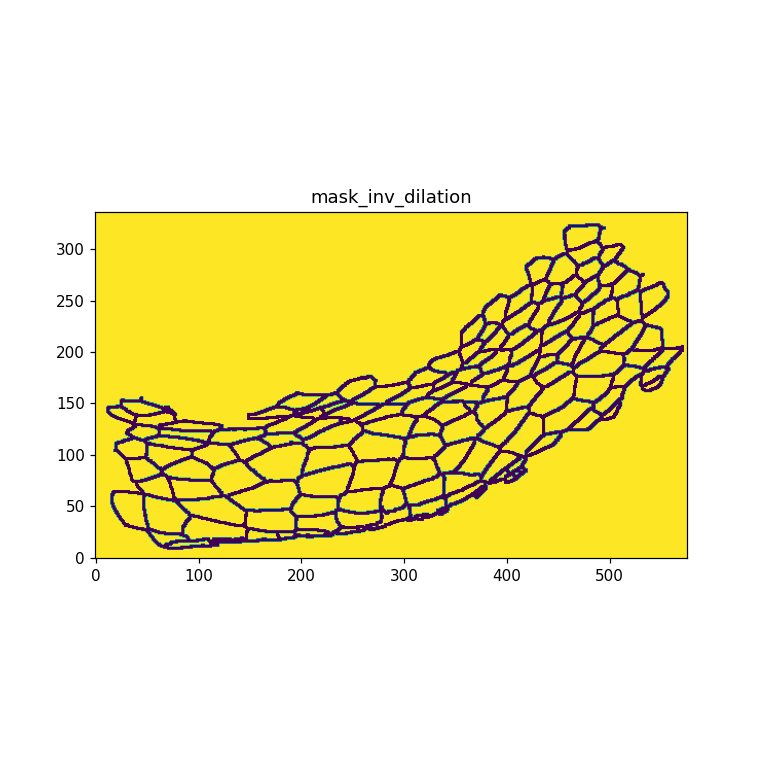

Text(0.5, 1.0, 'mask_inv_dilation')

In [40]:
from Dissects.image import dilation
# elargissement
mask_dilation = dilation(mask, 1)
plt.figure(figsize=(7,7))
plt.imshow(mask_dilation, origin='lower')
plt.title('mask_dilation')

mask_inv_dilation = (~mask_dilation.astype(bool)).astype(int)
plt.figure(figsize=(7,7))
plt.imshow(mask_inv_dilation,origin='lower')
plt.title('mask_inv_dilation')



<IPython.core.display.Javascript object>


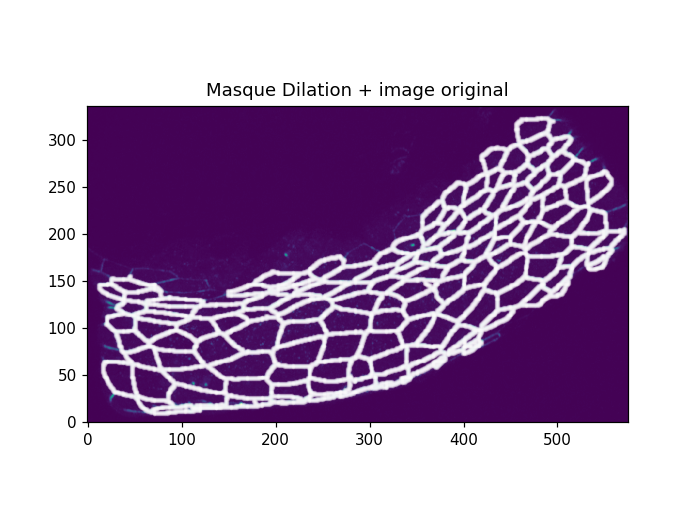

Text(0.5, 1.0, 'Masque Dilation + image original')

In [41]:
fig, ax = plt.subplots()
ax.imshow(image, origin='lower')
y,x = np.where(mask_dilation != 0)
ax.scatter(x,y, alpha=0.2, s=2, color='white')
plt.title('Masque Dilation + image original')

<IPython.core.display.Javascript object>


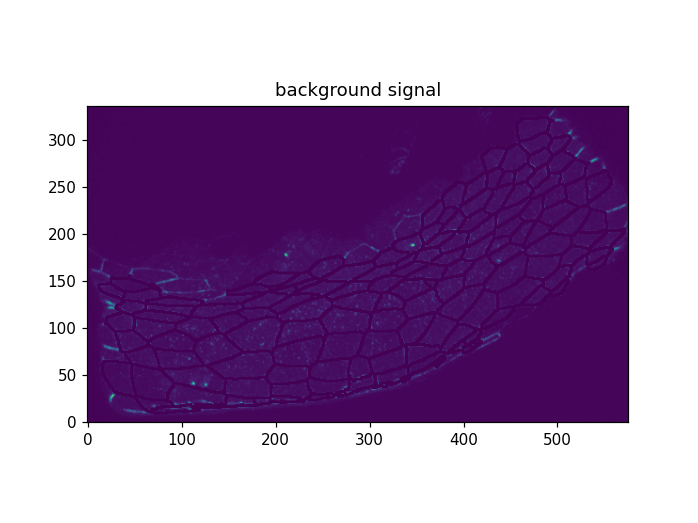

<IPython.core.display.Javascript object>


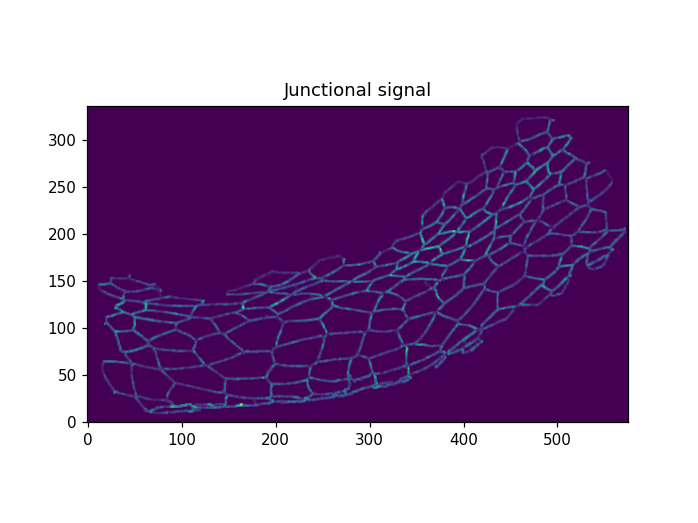

Text(0.5, 1.0, 'Junctional signal')

In [42]:
# Background
plt.figure()
plt.imshow(mask_inv_dilation * image, origin='lower')
plt.title('background signal')


#Junction
plt.figure()
plt.imshow(mask_dilation*image, origin='lower')
plt.title('Junctional signal')


In [43]:
#from Dissects.analysis import general_analysis
print('mean background =',general_analysis(image, mask_dilation)[0], ',',
      'std =', general_analysis(image, mask_dilation)[1])

print('mean junctional signal=',general_analysis(image, mask_dilation)[2], ',',
      'std =', general_analysis(image, mask_dilation)[3])


mean background = 679.6201338418364 , std = 671.7302549690124
mean junctional signal= 5600.43290185754 , std = 3750.4964749497253


In [44]:
%matplotlib notebook

# Segmentation


In [45]:
seg = segmentation(mask, 10)

<IPython.core.display.Javascript object>


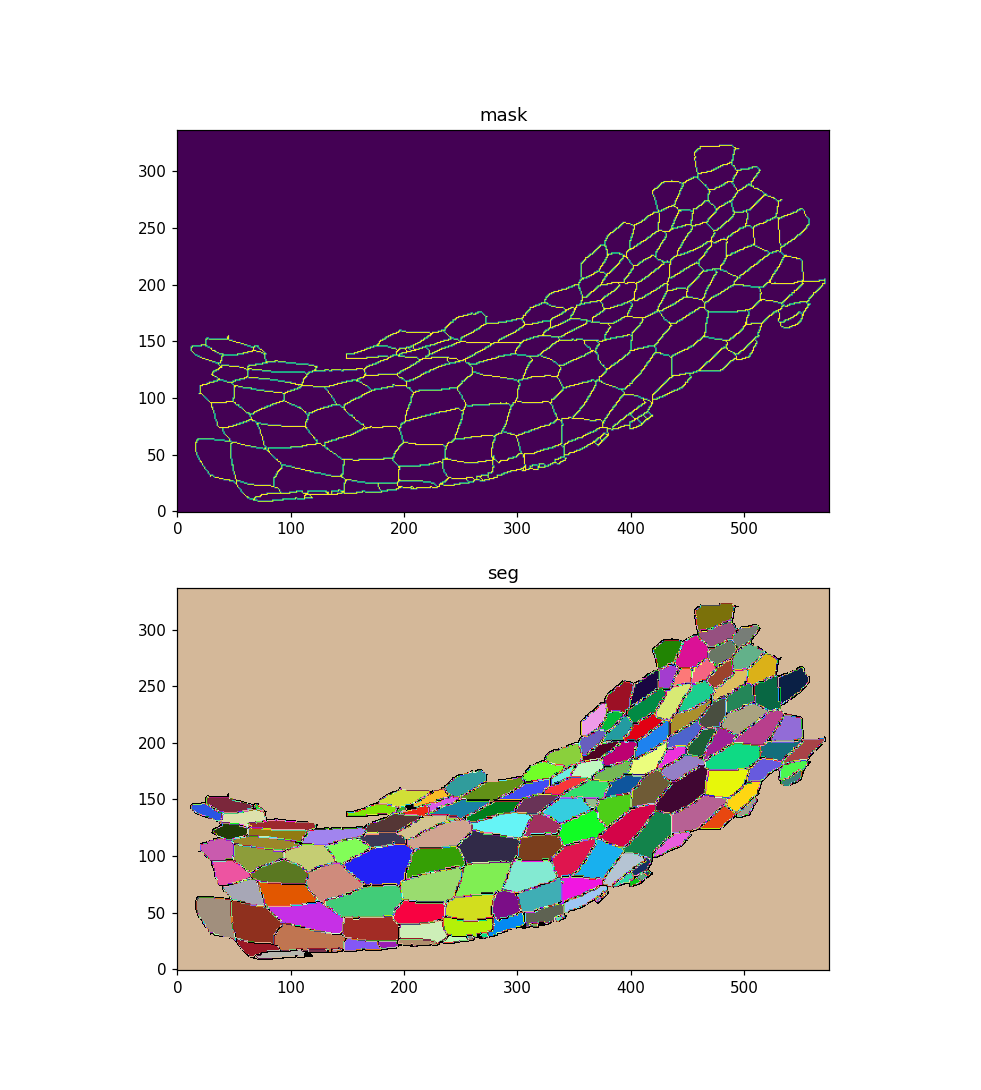

Text(0.5, 1.0, 'seg')

In [46]:
from matplotlib.colors import ListedColormap
rand = np.random.rand(256,3)
rand[0] = 0
cmap_rand = ListedColormap(rand)


plt.figure(figsize=(9,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(mask, origin='lower')
ax1.set_title('mask')
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(seg, cmap=cmap_rand, origin='lower')
ax2.set_title('seg')

<IPython.core.display.Javascript object>


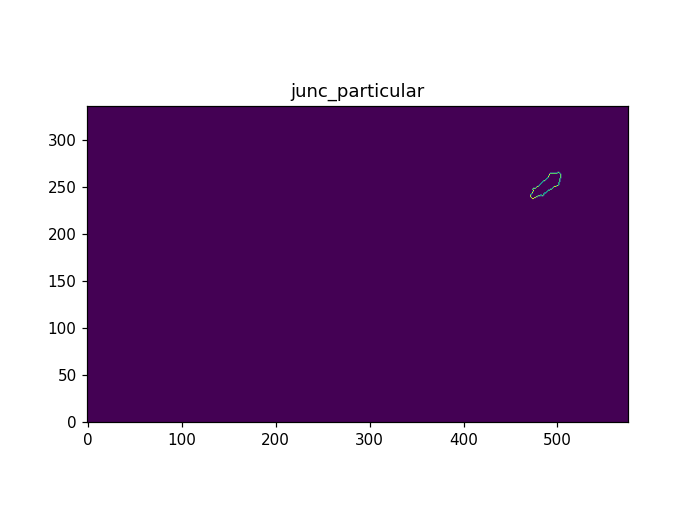

Text(0.5, 1.0, 'junc_particular')

In [47]:
junc_particular = junction_around_cell(mask, seg, 151)

plt.figure()
plt.imshow(junc_particular, origin='lower')
plt.title('junc_particular')

In [48]:
df_alphacat=cellstats(image, mask, 1, seg, 'alpha-cat', 1/pixel_ratio)

/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [49]:
df_alphacat

,CellNbr,perimeter_um,areaCell_um2,meanCell_alpha-cat,stdCell_alpha-cat,semCell_alpha-cat,meanJunc_alpha-cat,stdJunc_alpha-cat,semJunc_alpha-cat
0,2.0,16.857261,6.714727,2325.550000,1758.058278,176.691505,7165.116129,4402.412673,250.444507
1,3.0,15.208181,9.400617,1260.055866,987.009273,73.979473,4935.668874,3419.218266,197.080464
2,5.0,6.413088,1.040783,NaN,NaN,NaN,6664.771930,4149.585752,390.360191
3,6.0,27.667895,33.707928,1378.391990,1232.943285,42.977701,6103.937381,4188.436616,182.624515
4,7.0,3.481391,0.436457,NaN,NaN,NaN,6092.621212,2816.138065,349.298937
...,...,...,...,...,...,...,...,...,...
145,159.0,15.208181,18.633367,1059.083710,326.265188,15.536438,6273.822086,4406.117504,244.407424
146,160.0,12.093252,11.347888,1239.024490,743.871658,47.621503,7830.208955,4412.621545,270.048053
147,161.0,11.177097,8.561277,1220.341040,459.630292,35.046481,7393.537190,3866.206012,249.044222
148,162.0,14.658487,14.235221,1105.221519,575.278855,32.413291,6351.563694,3839.969293,217.047897


# Vertices méthode Tatiana 



In [50]:
images_v, list_vertices, df_vertices = vertices(mask)

In [51]:
list_vertices

(array([ 12,  15,  15,  16,  18,  20,  21,  22,  22,  25,  25,  25,  26,
         27,  27,  28,  28,  29,  29,  30,  31,  32,  36,  37,  37,  38,
         38,  40,  41,  43,  43,  45,  46,  47,  48,  50,  51,  54,  57,
         57,  58,  59,  60,  61,  61,  62,  64,  65,  66,  67,  71,  73,
         73,  73,  73,  74,  74,  74,  75,  75,  75,  76,  80,  80,  81,
         81,  82,  82,  85,  85,  86,  88,  89,  92,  93,  94,  94,  96,
         96,  97,  98,  98,  99,  99, 103, 104, 105, 107, 108, 109, 109,
        110, 110, 111, 112, 114, 115, 115, 115, 116, 117, 119, 119, 121,
        121, 122, 123, 125, 125, 129, 130, 131, 131, 134, 135, 135, 136,
        136, 136, 137, 138, 138, 138, 139, 139, 139, 139, 140, 140, 140,
        141, 141, 141, 141, 142, 142, 142, 142, 144, 145, 145, 145, 145,
        146, 146, 147, 149, 149, 149, 150, 150, 150, 150, 151, 151, 151,
        151, 152, 153, 154, 155, 160, 162, 165, 166, 166, 166, 166, 167,
        167, 168, 168, 170, 170, 171, 172, 176, 177

In [52]:
pd.set_option('display.max_rows', None)
df_vertices

,x_0,y_0,Cell_1,Cell_2,Cell_3,Cell_4,Cell_5
0,12.0,112.0,1.0,2.0,4.0,NaN,NaN
1,15.0,117.0,1.0,4.0,5.0,6.0,NaN
2,15.0,136.0,1.0,6.0,7.0,NaN,NaN
3,16.0,91.0,2.0,3.0,6.0,NaN,NaN
4,18.0,180.0,1.0,8.0,9.0,NaN,NaN
5,20.0,207.0,1.0,10.0,11.0,NaN,NaN
6,22.0,85.0,3.0,6.0,12.0,NaN,NaN
7,22.0,229.0,1.0,11.0,13.0,NaN,NaN
8,44.0,50.0,1.0,3.0,12.0,15.0,36.0
9,25.0,177.0,8.0,9.0,16.0,NaN,NaN


<IPython.core.display.Javascript object>


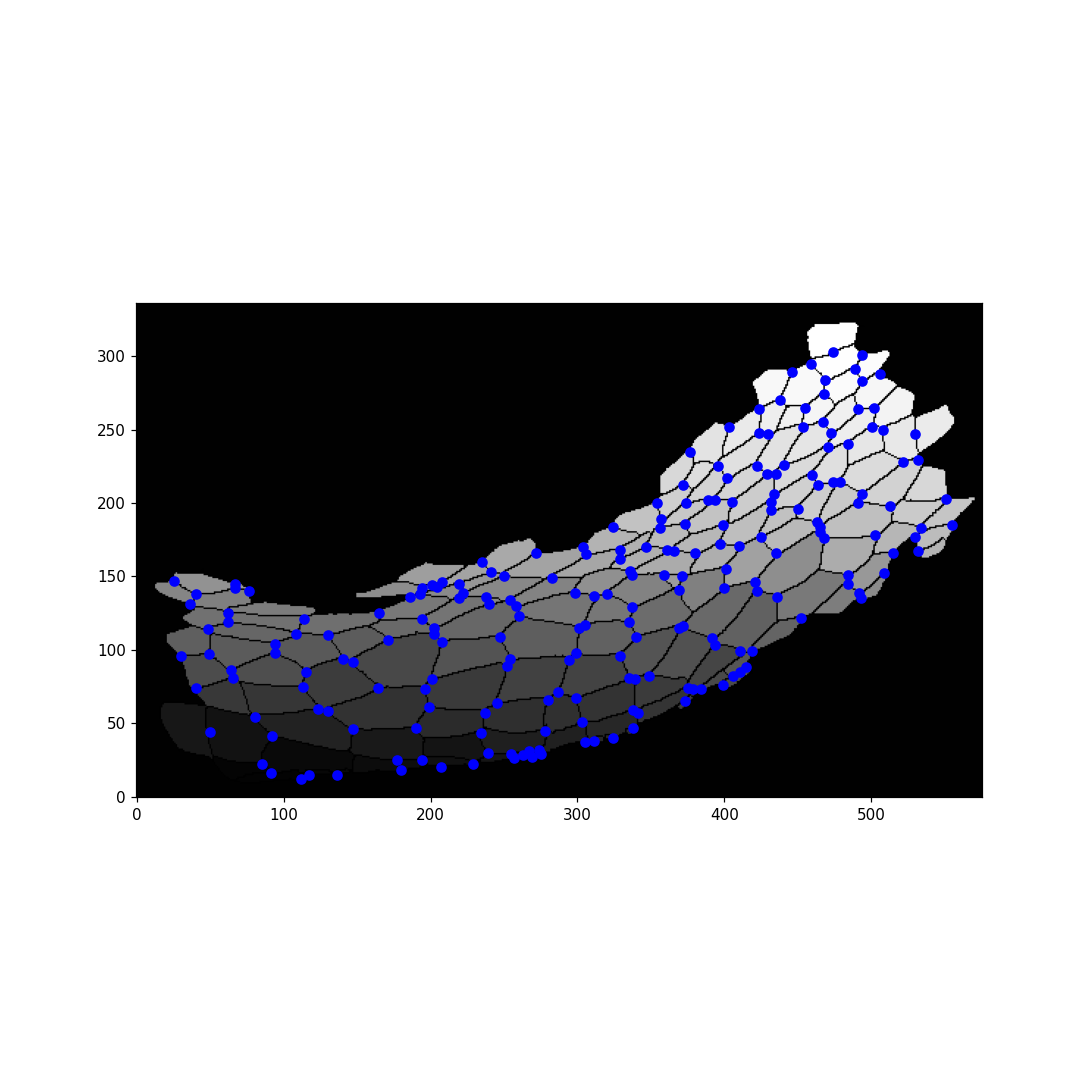

In [53]:
seg0 = segmentation(mask, 0)
plt.figure(figsize=(10,10))
plt.imshow(seg0, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(df_vertices['y_0'], df_vertices['x_0'], color='b')

In [54]:
df_vertices

,x_0,y_0,Cell_1,Cell_2,Cell_3,Cell_4,Cell_5
0,12.0,112.0,1.0,2.0,4.0,NaN,NaN
1,15.0,117.0,1.0,4.0,5.0,6.0,NaN
2,15.0,136.0,1.0,6.0,7.0,NaN,NaN
3,16.0,91.0,2.0,3.0,6.0,NaN,NaN
4,18.0,180.0,1.0,8.0,9.0,NaN,NaN
5,20.0,207.0,1.0,10.0,11.0,NaN,NaN
6,22.0,85.0,3.0,6.0,12.0,NaN,NaN
7,22.0,229.0,1.0,11.0,13.0,NaN,NaN
8,44.0,50.0,1.0,3.0,12.0,15.0,36.0
9,25.0,177.0,8.0,9.0,16.0,NaN,NaN


In [55]:
df4_jonctions = junctions(list_vertices, df_vertices)

In [56]:
df4_jonctions

,Cell1,Cell2,x0,y0,x1,y1
0,3.0,6.0,22.0,85.0,16.0,91.0
1,3.0,12.0,44.0,50.0,22.0,85.0
2,6.0,12.0,41.0,92.0,22.0,85.0
3,9.0,16.0,25.0,194.0,25.0,177.0
4,14.0,20.0,30.0,239.0,29.0,255.0
5,13.0,20.0,43.0,234.0,30.0,239.0
6,19.0,20.0,32.0,274.0,31.0,267.0
7,20.0,21.0,45.0,278.0,32.0,274.0
8,12.0,22.0,54.0,80.0,41.0,92.0
9,21.0,31.0,51.0,303.0,45.0,278.0


<IPython.core.display.Javascript object>


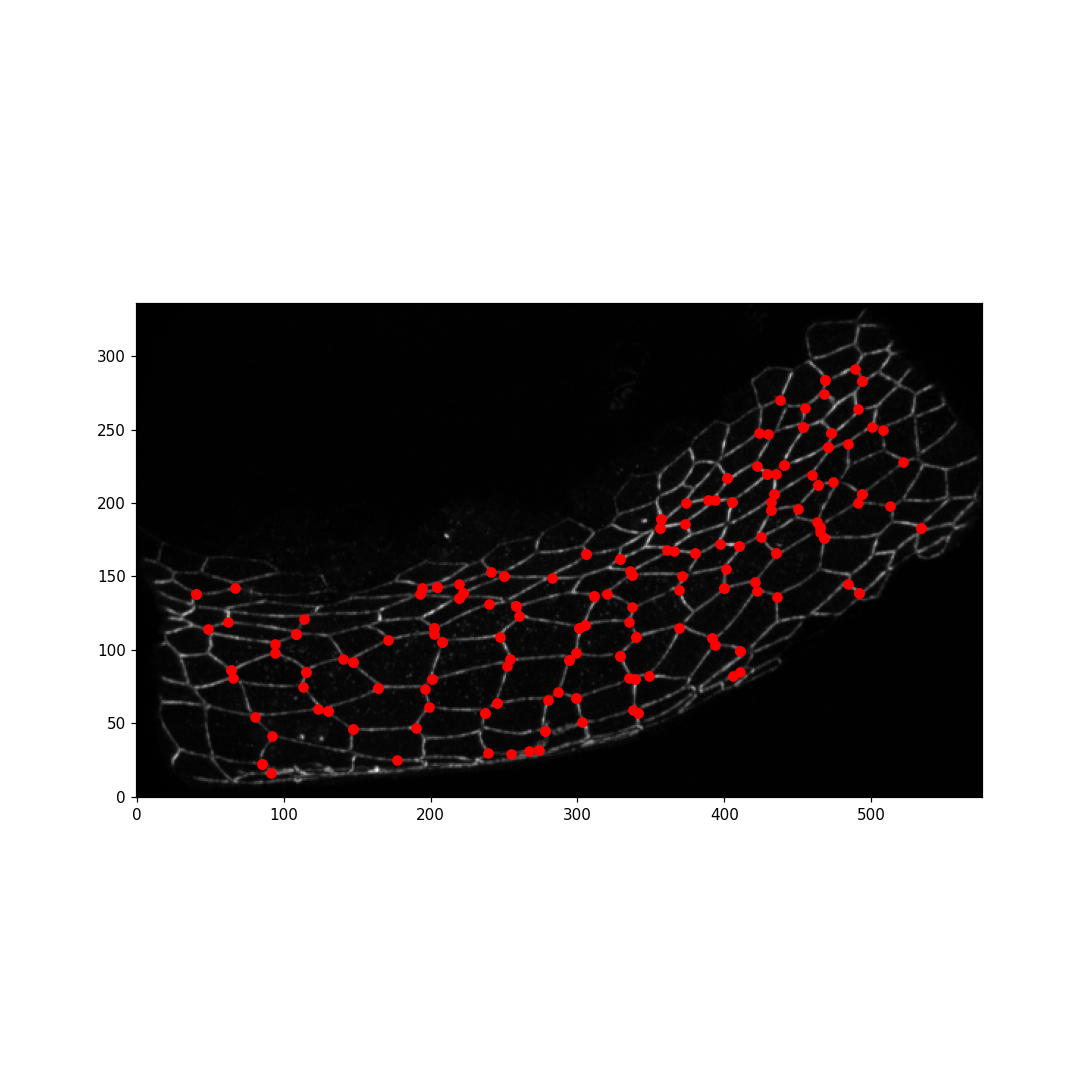

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(image, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(df4_jonctions['y1'], df4_jonctions['x1'], color='r')

<IPython.core.display.Javascript object>


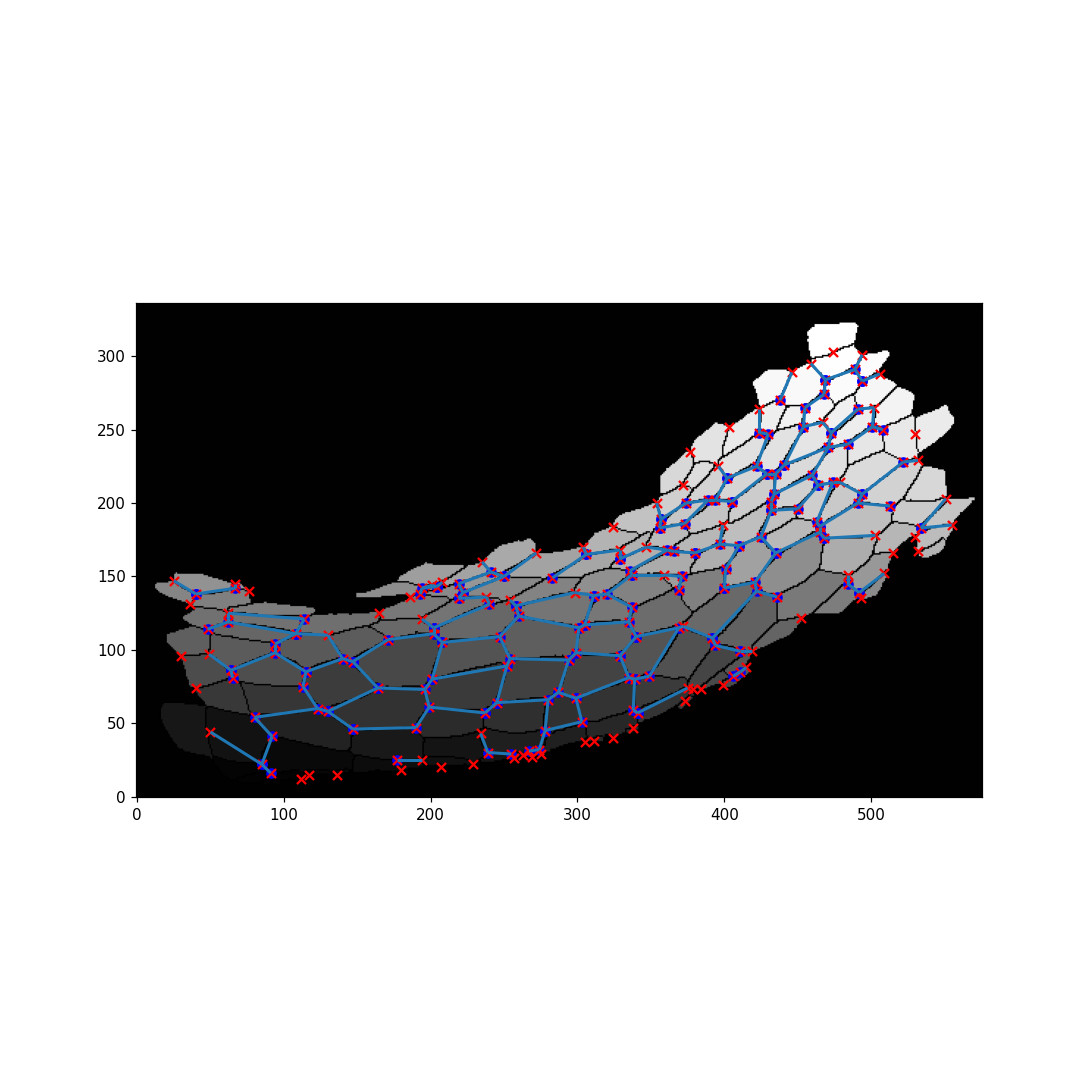

In [58]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc

lines=[]
for i in range (0, df4_jonctions.shape[0]) :
    lines.append(([(df4_jonctions['y0'][i],df4_jonctions['x0'][i]),
                   (df4_jonctions['y1'][i],df4_jonctions['x1'][i])]))



cc = df4_jonctions['x0']
lc = mc.LineCollection(lines, cc, cmap='plasma_r', linewidth=2, alpha=1)

fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc)
#ax.autoscale()
#ax.margins(0.1)
#ax.scatter(x,y,color='r', zorder=10, s = 7)
ax.set_aspect('equal')

#plt.imshow(image, origin='lower')

plt.imshow(seg, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(df4_jonctions['y1'], df4_jonctions['x1'], color='b')
plt.scatter(df_vertices['y_0'], df_vertices['x_0'], color='r', marker='x')

In [59]:
offset= -25

df4_jonctions_verticales1 = df4_jonctions.loc[df4_jonctions['angle'] < -45 + offset] 
df4_jonctions_verticales2 = df4_jonctions.loc[df4_jonctions['angle'] > 45 + offset] 
df4_jonctions_verticales = pd.concat([df4_jonctions_verticales1, df4_jonctions_verticales2])

df4_jonctions_horizontales = df4_jonctions.loc[(df4_jonctions['angle'] > -45+ offset)&(df4_jonctions['angle']< 45 + offset)] 


KeyError: 'angle'

<IPython.core.display.Javascript object>


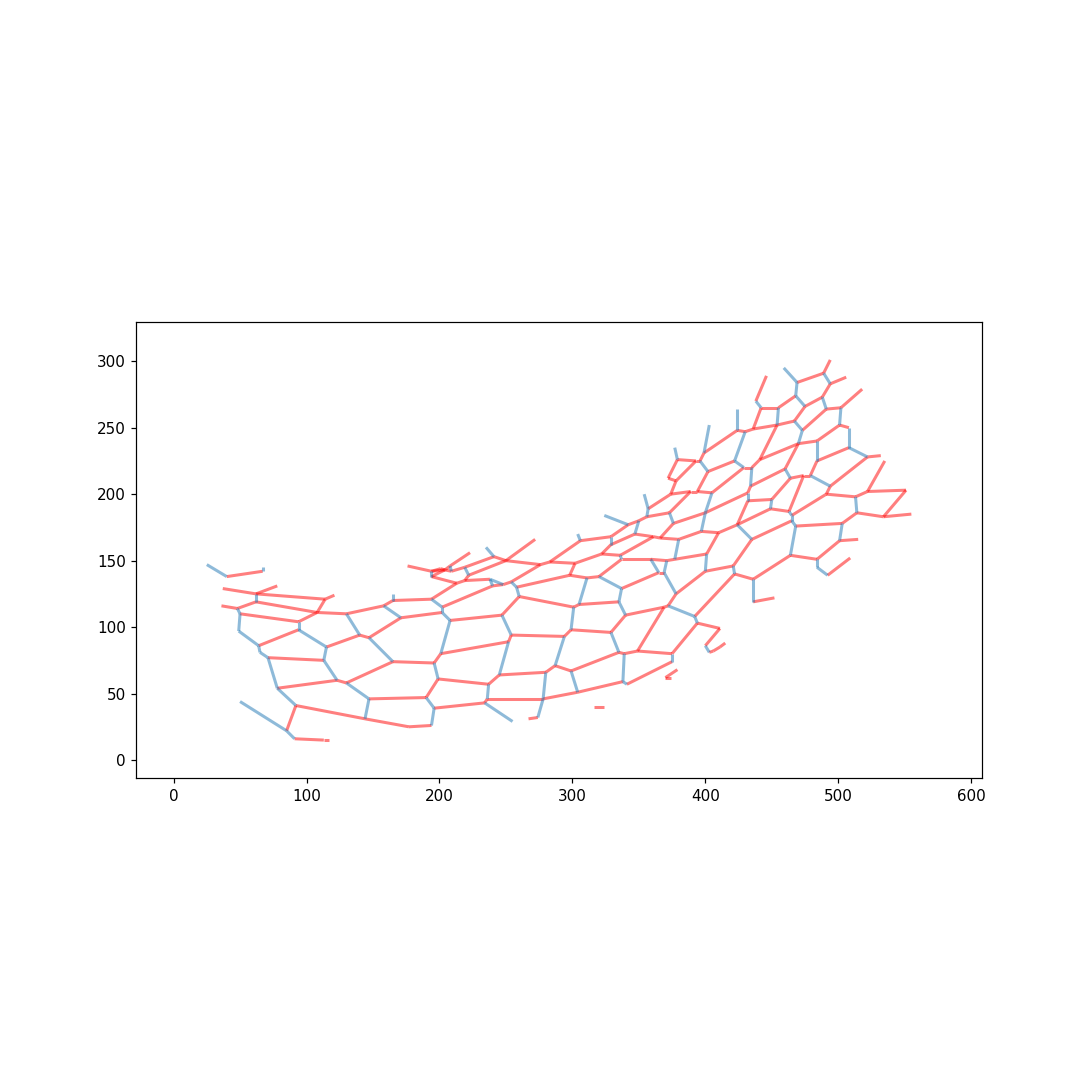

In [35]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc
    
lines2=[]
for i in df4_jonctions_horizontales.index :
    lines2.append(([(df4_jonctions_horizontales['y0'][i],df4_jonctions_horizontales['x0'][i]),
                   (df4_jonctions_horizontales['y1'][i],df4_jonctions_horizontales['x1'][i])]))


lines=[]
for i in df4_jonctions_verticales.index :
    lines.append(([(df4_jonctions_verticales['y0'][i],df4_jonctions_verticales['x0'][i]),
                   (df4_jonctions_verticales['y1'][i],df4_jonctions_verticales['x1'][i])]))



cc1 = df4_jonctions['x0']
cc2 = df4_jonctions['y0']

lc1 = mc.LineCollection(lines, cc1, colors = 'r', linewidth=2, alpha=0.5)
lc2 = mc.LineCollection(lines2, cc2, cmap='magma', linewidth=2, alpha=0.5)

fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc1)
ax.add_collection(lc2)
ax.set_aspect('equal')
ax.margins(0.1)
#plt.scatter(x,y,color='r', zorder=10, s = 7)

# Ellipses

In [392]:
from astropy.modeling import models, fitting
from astropy.modeling.models import Ellipse2D
from astropy.coordinates import Angle
import warnings
%matplotlib inline
# fitting procedure
fit = fitting.SimplexLSQFitter() 
#fit = fitting.LevMarLSQFitter()

In [402]:
seg=segmentation(mask,10)

In [403]:
from multiprocessing import Pool
from itertools import repeat
import time



def Cell(seg,i):   
    segmentationi = np.zeros_like(seg)
    #for each cell get contour pixels
    segmentationi[np.where(seg == i)] = 1
    return segmentationi

def cellgeoi(inputs):
    ind,i,seg = inputs
    print(i)

    #Ellipse
    imCell = Cell(seg,i)
    # gaussian fit (to estimate x_0, y_0 and theta)
    gi = models.Gaussian2D(amplitude = 1.,
                           x_mean = np.where(imCell==1)[1][int(len(np.where(imCell == 1)[0]) / 2) + 1],
                           y_mean = np.where(imCell == 1)[0][int(len(np.where(imCell == 1)[0]) / 2) + 1], 
                           x_stddev=10, y_stddev=10, theta=0.0) #modèle initial
    
    g1 = fit(gi, x, y, imCell, maxiter=100000) #fit une gaussienne avec les parametres initiaux donnés
    # initial model: fais une ellipse fixe avec les parametres trouvés par le fit gaussien
    
    ei1 = models.Ellipse2D(amplitude=1.,
                           x_0=g1.x_mean, 
                           y_0=g1.y_mean, 
                           a=g1.x_stddev, 
                           b=g1.y_stddev,
                           theta=g1.theta, 
                           fixed={'x_0': True, 'y_0':True, 'theta':True})
    
    #fitted model : on fit une ellipse et donc on change a et b 
    e1 = fit(ei1, x, y, imCell, maxiter=100000)
    e1.amplitude = 1
    z1 = e1(x, y)
    
    if e1.b.value > e1.a.value:
        e1.theta.value = e1.theta.value + np.pi/2 
        c = e1.a.value  
        e1.a.value = e1.b.value 
        e1.b.value = c
    
    return e1


In [404]:
start = time.time()
y, x = np.mgrid[0:np.shape(seg)[0], 0:np.shape(seg)[1]] #grille 
init = np.zeros((len(np.unique(seg)[2:]),5))
Dataframe_geo_para = pd.DataFrame(data=init,columns=['x_0','y_0','a','b','theta'])

all_inputs = zip(range(len(np.unique(seg)[2:])),np.unique(seg)[2:],repeat(seg))

pool = Pool(4)
CellGeo= pool.map_async(cellgeoi, all_inputs)
pool.close()
pool.join()
e1l = CellGeo.get()

for ind,i in enumerate(np.unique(seg)[2:]):
    print(i)
    Dataframe_geo_para['x_0'][ind] = e1l[ind].x_0.value
    Dataframe_geo_para['y_0'][ind] = e1l[ind].y_0.value
    Dataframe_geo_para['a'][ind] = e1l[ind].a.value
    Dataframe_geo_para['b'][ind] = e1l[ind].b.value
    Dataframe_geo_para['theta'][ind] = e1l[ind].theta.value

Dataframe_geo_para['e'] = np.sqrt( 1 - (Dataframe_geo_para['b']**2 / (Dataframe_geo_para['a']**2) ))
Dataframe_geo_para['an'] = Dataframe_geo_para['a'] / Dataframe_geo_para['b']
Dataframe_geo_para['a um'] = Dataframe_geo_para['a'] * pixel_ratio
Dataframe_geo_para['b um'] = Dataframe_geo_para['b'] * pixel_ratio

#Dataframe_geo_para['e'] = np.sqrt( 1 - (Dataframe_geo_para['b']**2 / (Dataframe_geo_para['a']**2) ))
#Dataframe_geo_para['an'] = Dataframe_geo_para['a'] / Dataframe_geo_para['b']

end=time.time()

print('Cell Geo 4 cores ran in ',(end-start)/60.,' min')

2
14
38
28
39
3
15
29
40
5
16
30
17
41
31
42
19
43
32
20
44
33
21
34
46
22
35
47
36
25
48
37
26
49
59
69
60
50
71
6
61
72
51
7
62
73
63
74
52
8
64
75
53
9
65
76
54
11
66
77
55
67
12
78
13
56
68
57
79
80
90
58
103
81
91
114
104
82
115
92
105
83
116
93
106
84
117
94
108
96
85
118
109
97
86
119
110
98
120
111
87
121
100
88
112
101
122
89
113
124
123
134
144
125
154
135
145
126
155
146
127
136
128
156
137
147
129
138
148
157
149
158
130
139
159
150
131
140
160
132
141
151
161
133
142
152
162
143
153
163
2
3
5
6
7
8
9
11
12
13
14
15
16
17
19
20
21
22
25
26
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
96
97
98
100
101
103
104
105
106
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
16

In [417]:
e1l

[<Ellipse2D(amplitude=1., x_0=90.82130799, y_0=13.10689449, a=22.98224028, b=2.62817447, theta=0.08152298)>,
 <Ellipse2D(amplitude=1., x_0=69.70326259, y_0=18.98775834, a=18.71737108, b=4.4836741, theta=-0.04745638)>,
 <Ellipse2D(amplitude=1., x_0=123.25137702, y_0=16.49724637, a=5.53990068, b=0.29213224, theta=-0.00139525)>,
 <Ellipse2D(amplitude=1., x_0=113.84720602, y_0=26.57065077, a=32.68521211, b=9.24131986, theta=-0.07947551)>,
 <Ellipse2D(amplitude=1., x_0=139.73774364, y_0=16.69955208, a=2.7656326, b=0.61483195, theta=-0.01620985)>,
 <Ellipse2D(amplitude=1., x_0=161.42172756, y_0=21.44071278, a=17.38239082, b=4.24556189, theta=-0.04526081)>,
 <Ellipse2D(amplitude=1., x_0=185.67815822, y_0=21.89255461, a=8.71146387, b=2.99030722, theta=0.02120187)>,
 <Ellipse2D(amplitude=1., x_0=210.12815217, y_0=23.90314238, a=17.30527032, b=2.80672187, theta=-0.03669564)>,
 <Ellipse2D(amplitude=1., x_0=67.55797821, y_0=40.8317037, a=22.54080759, b=16.51687323, theta=-0.49725664)>,
 <Ellipse2D

In [418]:
Dataframe_geo_para

,x_0,y_0,a,b,theta,e,an,a um,b um
0,90.821308,13.106894,22.982240,2.628174,0.081523,0.993440,8.744564,4.211061,0.481563
1,69.703263,18.987758,18.717371,4.483674,-0.047456,0.970885,4.174561,3.429604,0.821549
2,123.251377,16.497246,5.539901,0.292132,-0.001395,0.998609,18.963675,1.015082,0.053528
3,113.847206,26.570651,32.685212,9.241320,-0.079476,0.959197,3.536855,5.988947,1.693297
4,139.737744,16.699552,2.765633,0.614832,-0.016210,0.974976,4.498193,0.506750,0.112656
5,161.421728,21.440713,17.382391,4.245562,-0.045261,0.969714,4.094250,3.184994,0.777919
6,185.678158,21.892555,8.711464,2.990307,0.021202,0.939240,2.913234,1.596211,0.547917
7,210.128152,23.903142,17.305270,2.806722,-0.036696,0.986760,6.165652,3.170864,0.514279
8,67.557978,40.831704,22.540808,16.516873,-0.497257,0.680493,1.364714,4.130177,3.026405
9,217.021632,33.354150,22.914479,7.242139,-0.026520,0.948742,3.164049,4.198645,1.326985


In [419]:
from multiprocessing import Pool
import time

In [420]:
Dataframe_geo_para.to_csv('Dataframe_geo_para.csv',index=False)
#Dataframe_geo_para = pd.read_csv('/home/tmerle/Dataframe_geo_para.csv')

In [421]:
np.mean(Dataframe_geo_para['a um'])

3.2241204116105027

In [422]:
from matplotlib.colors import LogNorm,PowerNorm

<IPython.core.display.Javascript object>


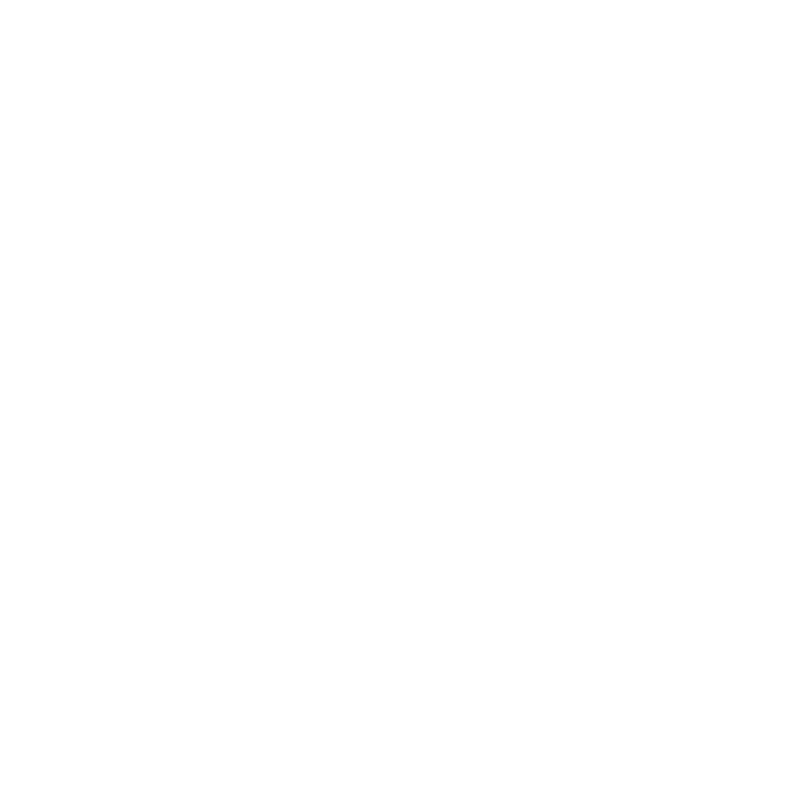

<IPython.core.display.Javascript object>


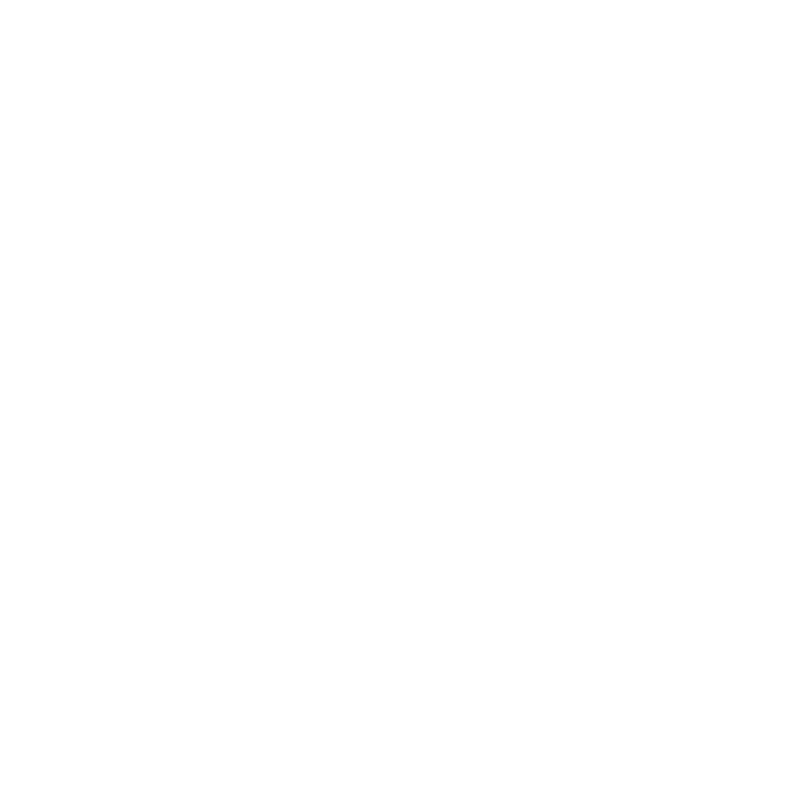

In [424]:
plt.figure(figsize=(10,10))
plt.imshow(seg,origin='lower',cmap=cmap_rand)
for i in range(len(Dataframe_geo_para)):
    startx = Dataframe_geo_para['x_0'][i] - Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    starty = Dataframe_geo_para['y_0'][i] - Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    endx = Dataframe_geo_para['x_0'][i] + Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    endy = Dataframe_geo_para['y_0'][i] + Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    
    
    plt.plot([startx, endx], [starty, endy], color='black')

<IPython.core.display.Javascript object>


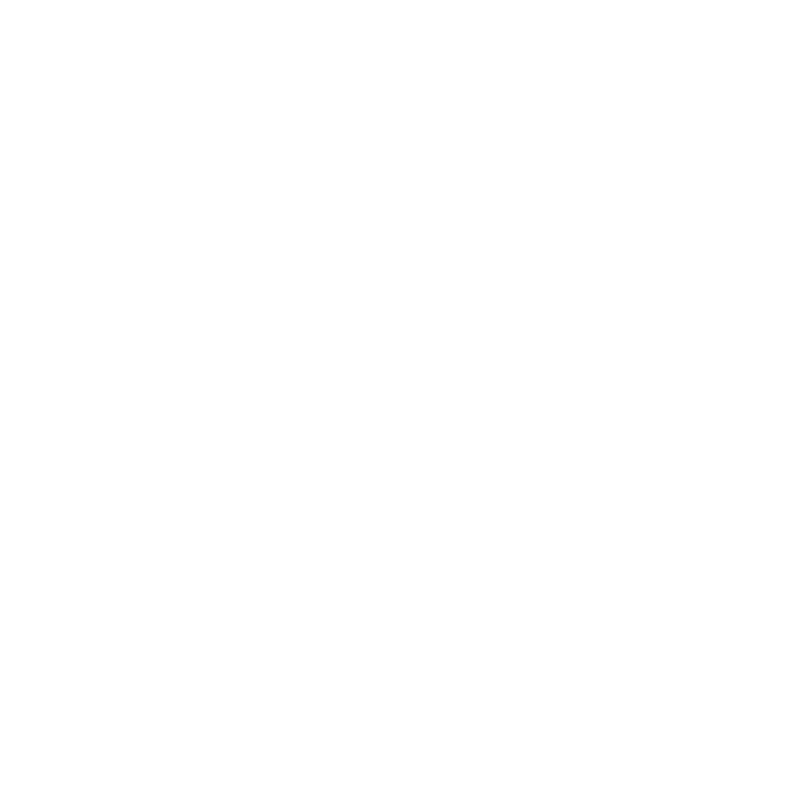

<IPython.core.display.Javascript object>


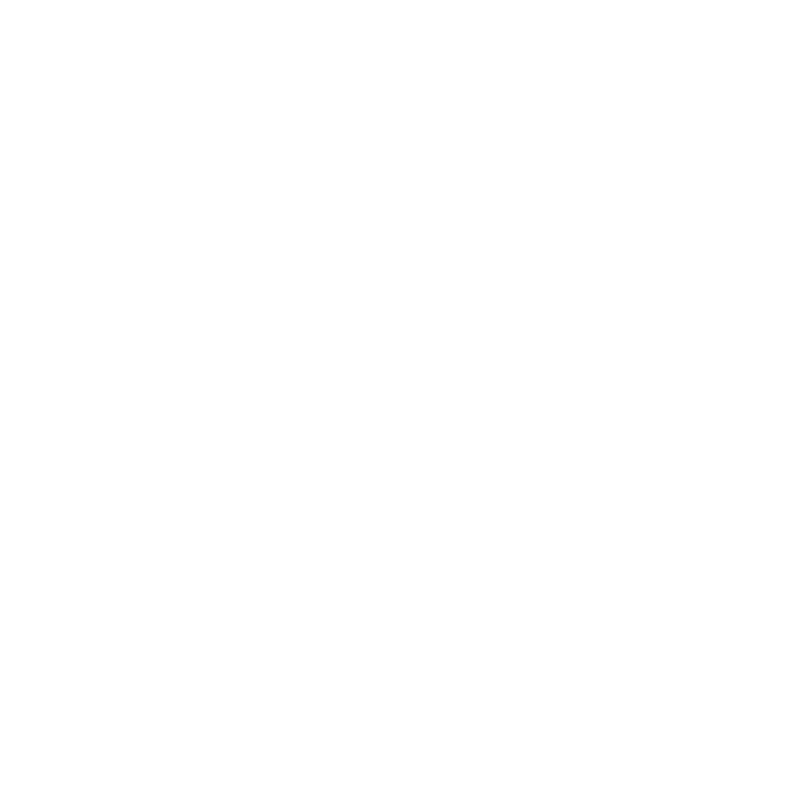

In [425]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
#plt.imshow(seg,origin='lower',cmap=cmap_rand)
for i in range(len(Dataframe_geo_para)):
    startx = Dataframe_geo_para['x_0'][i] - Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    starty = Dataframe_geo_para['y_0'][i] - Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    endx = Dataframe_geo_para['x_0'][i] + Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    endy = Dataframe_geo_para['y_0'][i] + Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])

    colori = plt.cm.jet(Dataframe_geo_para['e'][i]) # r is 0 to 1 inclusive
        
    plt.plot([startx, endx], [starty, endy], color=colori)
   
#plt.colorbar(Dataframe_geo_para_bis['e'])

In [413]:
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [414]:
'''Fonction pour la jolie color bar'''

from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [415]:
%matplotlib notebook

<IPython.core.display.Javascript object>


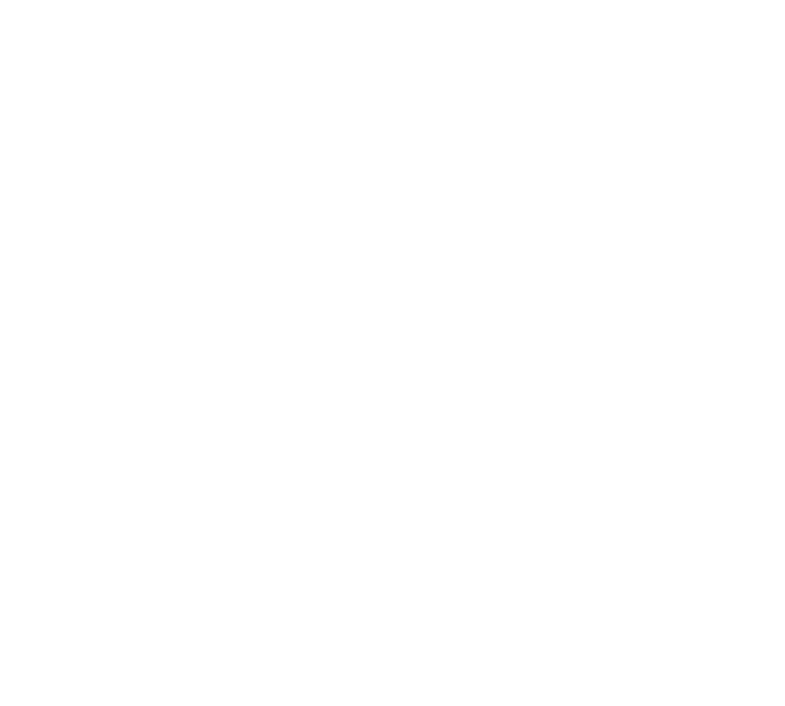

<IPython.core.display.Javascript object>


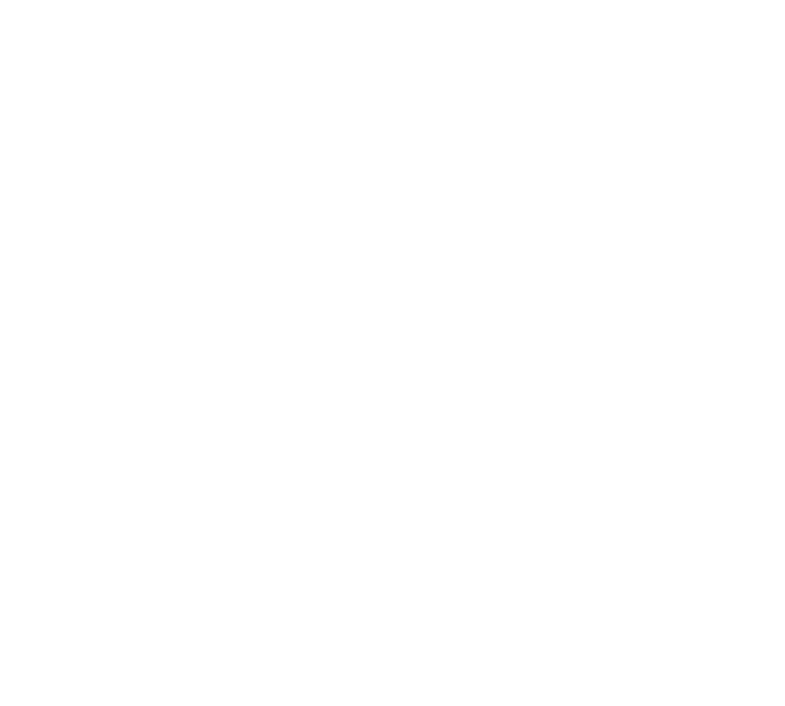

In [416]:
fig = plt.figure(figsize=(10,9))
ax.set_aspect('equal')
#plt.imshow(seg,origin='lower',cmap='viridis')
plt.imshow(mask,origin='lower',cmap='gist_gray')
xs = []
ys = []
for i in range(len(Dataframe_geo_para)):
    startx = Dataframe_geo_para['x_0'][i] - Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    starty = Dataframe_geo_para['y_0'][i] - Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    endx = Dataframe_geo_para['x_0'][i] + Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    endy = Dataframe_geo_para['y_0'][i] + Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    
    xs.append([startx,endx])
    ys.append([starty,endy])
c = Dataframe_geo_para['an']
lc = multiline(xs, ys, c, cmap='jet', lw=2, clim = (0,8))
add_colorbar(lc, aspect=0.05, pad_fraction=0.5, label = 'Anisotropy (a/b)')